In [3]:
%pylab inline
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import scanpy as sc
import pandas as pd
import torch
import scipy
import time
from model import *
from utils import *

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [4]:
scdata = pd.read_csv('./data/mousedata_2020/E1z2/simu_sc_counts.csv',index_col=0)
scdata = scdata.T
stdata = pd.read_csv('data/mousedata_2020/E1z2/simu_st_counts.csv',index_col=0)
stdata = stdata.T
stgtcelltype = pd.read_csv('./data/mousedata_2020/E1z2/simu_st_celltype.csv',index_col=0)
spcoor = pd.read_csv('./data/mousedata_2020/E1z2/simu_st_metadata.csv',index_col=0)
scmetadata = pd.read_csv('./data/mousedata_2020/E1z2/metadata.csv',index_col=0)

adata = sc.AnnData(scdata,obs=scmetadata)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
scdata = pd.DataFrame(adata.X,index=adata.obs_names,columns=adata.var_names)
stadata = sc.AnnData(stdata)
sc.pp.normalize_total(stadata)
sc.pp.log1p(stadata)
stdata = pd.DataFrame(stadata.X,index=stadata.obs_names,columns=stadata.var_names)

adata.obsm['spatial'] = scmetadata[['x_global','y_global']].values
stadata.obsm['spatial'] = spcoor

In [5]:
sc.pp.calculate_qc_metrics(adata,percent_top=None, log1p=False, inplace=True)
adata.obs['n_genes_by_counts'].median()

sc.pp.calculate_qc_metrics(stadata,percent_top=None, log1p=False, inplace=True)
stadata.obs['n_genes_by_counts'].median()

dp = 1- adata.obs['n_genes_by_counts'].median()/stadata.obs['n_genes_by_counts'].median()
dp

0.5836734693877551

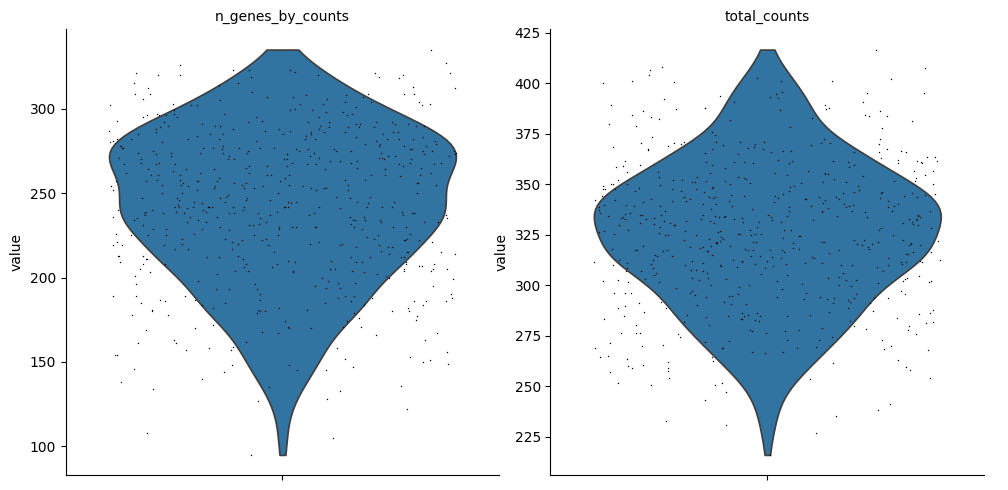

In [6]:
figsize(2,2)
sc.pl.violin(stadata, ['n_genes_by_counts', 'total_counts'],jitter=0.4, multi_panel=True)

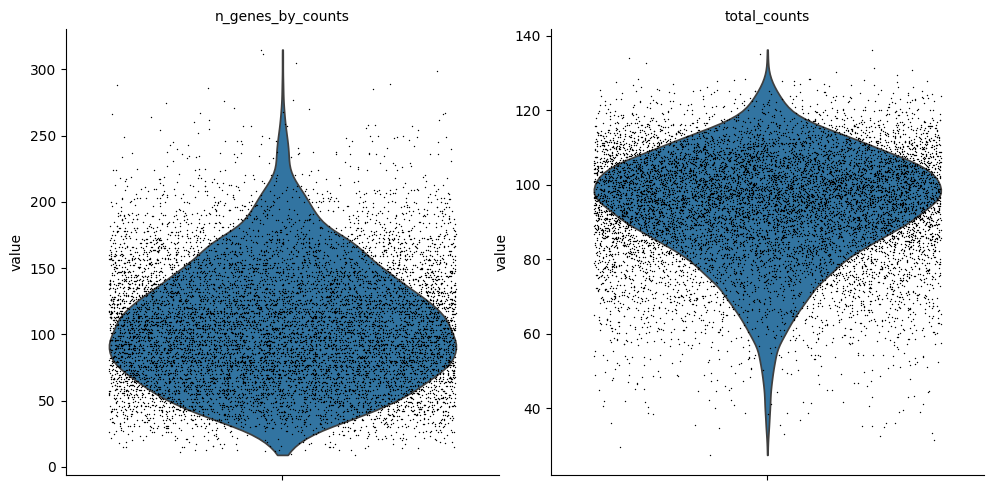

In [7]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],jitter=0.4, multi_panel=True)

In [9]:
st_neighbor = scipy.spatial.distance.cdist(spcoor,spcoor)
sigma = 3
st_neighbor = np.exp(-st_neighbor**2/(2*sigma**2))/(np.sqrt(2*np.pi)*sigma)

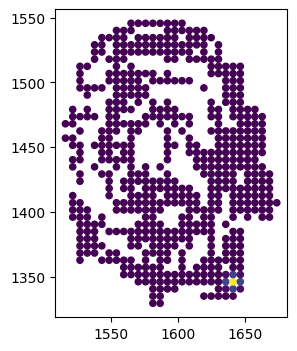

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3,4))
plt.scatter(spcoor.values[:,0],spcoor.values[:,1],c=np.log1p(st_neighbor[30,:]),s=20)

In [11]:
class setting( object ):
    pass
seed_all(2022)
opt= setting()
setattr(opt, 'device', 'cuda:0')
setattr(opt, 'outf', 'log/Mouse_E1z2')
setattr(opt, 'n_genes', 351)
setattr(opt, 'no_bn', False)
setattr(opt, 'lr', 0.002)
setattr(opt, 'sigma', 3)
setattr(opt, 'alpha', 0.8)
setattr(opt, 'verbose', True)
setattr(opt, 'mmdbatch', 1000)
setattr(opt, 'dp', dp)

In [12]:
%%time
testmodel = SOmodel(opt)
testmodel.togpu()
loss_curve = testmodel.train_wholedata(400,torch.tensor(scdata.values).float(),torch.tensor(stdata.values).float(),torch.tensor(spcoor.values).float())

[Train][0] Loss: E 3.622 E_pred 3.580 E_circle 5.305 E_mmd 0.053
[0.002]
[Train][1] Loss: E 4.889 E_pred 4.849 E_circle 5.323 E_mmd 0.050
[0.002]
[Train][2] Loss: E 4.316 E_pred 4.288 E_circle 5.360 E_mmd 0.035
[0.002]
[Train][3] Loss: E 3.460 E_pred 3.439 E_circle 4.874 E_mmd 0.026
[0.002]
[Train][4] Loss: E 3.587 E_pred 3.564 E_circle 4.835 E_mmd 0.029
[0.002]
[Train][5] Loss: E 3.341 E_pred 3.315 E_circle 4.770 E_mmd 0.032
[0.002]
[Train][6] Loss: E 3.517 E_pred 3.493 E_circle 4.829 E_mmd 0.030
[0.002]
[Train][7] Loss: E 3.225 E_pred 3.202 E_circle 4.449 E_mmd 0.030
[0.002]
[Train][8] Loss: E 3.191 E_pred 3.165 E_circle 4.274 E_mmd 0.032
[0.002]
[Train][9] Loss: E 3.096 E_pred 3.074 E_circle 4.153 E_mmd 0.028
[0.002]
[Train][10] Loss: E 3.071 E_pred 3.044 E_circle 4.119 E_mmd 0.034
[0.002]
[Train][11] Loss: E 3.085 E_pred 3.060 E_circle 4.137 E_mmd 0.031
[0.002]
[Train][12] Loss: E 3.017 E_pred 2.993 E_circle 4.046 E_mmd 0.030
[0.002]
[Train][13] Loss: E 2.937 E_pred 2.915 E_circle 

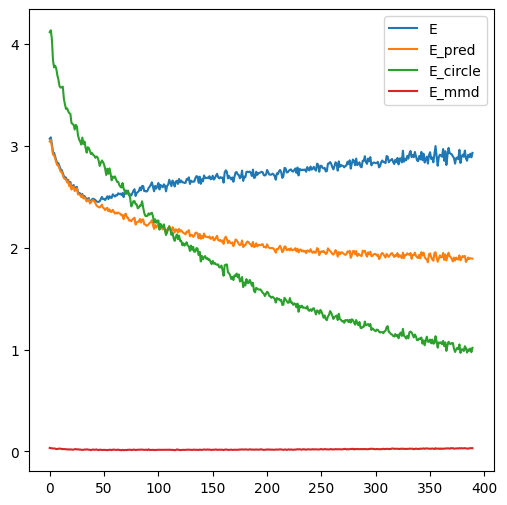

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
skip=10
N = len(loss_curve['E'])-skip
plt.plot(np.arange(N),loss_curve['E'][skip:],label='E')
plt.plot(np.arange(N),loss_curve['E_pred'][skip:],label='E_pred')
plt.plot(np.arange(N),loss_curve['E_circle'][skip:],label='E_circle')
plt.plot(np.arange(N),loss_curve['E_mmd'][skip:],label='E_mmd')
plt.legend()

In [15]:
testmodel.modeleval()
scembedding = testmodel.netE(torch.tensor(scdata.values,dtype=torch.float32).cuda())
stembedding = testmodel.netE(torch.tensor(stdata.values,dtype=torch.float32).cuda())
netst2sc = F.softmax(stembedding.mm(scembedding.t()),dim=1).detach().cpu().numpy()
netsc2st = F.softmax(scembedding.mm(stembedding.t()),dim=1).detach().cpu().numpy()

In [ ]:
# np.save('result/230215_testdp_pure_mmd-E1z2.npy',netst2sc)
# np.save('result/230215_testdp_pure_sc2st_mmd-E1z2.npy',netsc2st)
# np.save('result/230215_scembbedding-E1z2.npy',scembedding.detach().cpu().numpy())
# np.save('result/230215_stembbedding-E1z2.npy',stembedding.detach().cpu().numpy())

In [16]:
testmodel.save()

In [17]:
def all_coord(mappingmtx,spcoor):
    mappingnorm = mappingmtx.div(mappingmtx.sum(axis=1), axis=0)

    spaotsc_coord = np.zeros([mappingnorm.shape[0],2])
    spaotsc_coord[:,0] = np.matmul(mappingnorm.values,spcoor.coord_x.values)
    spaotsc_coord[:,1] = np.matmul(mappingnorm.values,spcoor.coord_y.values)
    return spaotsc_coord

def k_coord(mappingmtx,spcoor, k=1):
    maskmap = np.zeros_like(mappingmtx)

    argmask = np.argsort(1/mappingmtx.values,axis=1)

    for i in range(argmask.shape[0]):
        for j in range(k):
            maskmap[i,argmask[i,j]]=1

    mappingnorm = (maskmap*mappingmtx).div((maskmap*mappingmtx).sum(axis=1), axis=0)

    spaotsc_coord = np.zeros([mappingnorm.shape[0],2])
    spaotsc_coord[:,0] = np.matmul(mappingnorm.values,spcoor.coord_x.values)
    spaotsc_coord[:,1] = np.matmul(mappingnorm.values,spcoor.coord_y.values)
    return spaotsc_coord

In [18]:
adata.obsm['spatialDA'] = all_coord(pd.DataFrame(netsc2st,index=adata.obs_names,columns=stadata.obs_names),spcoor)

In [19]:
adata.obsm['spatialDA']

array([[1626.64183715, 1348.78184598],
       [1626.00605288, 1348.36009501],
       [1627.69029001, 1336.64430242],
       ...,
       [1548.77815794, 1535.75857385],
       [1556.11161327, 1524.5116776 ],
       [1553.55199314, 1519.19439761]])

/tmp/ipykernel_4095702/3057971461.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_types))


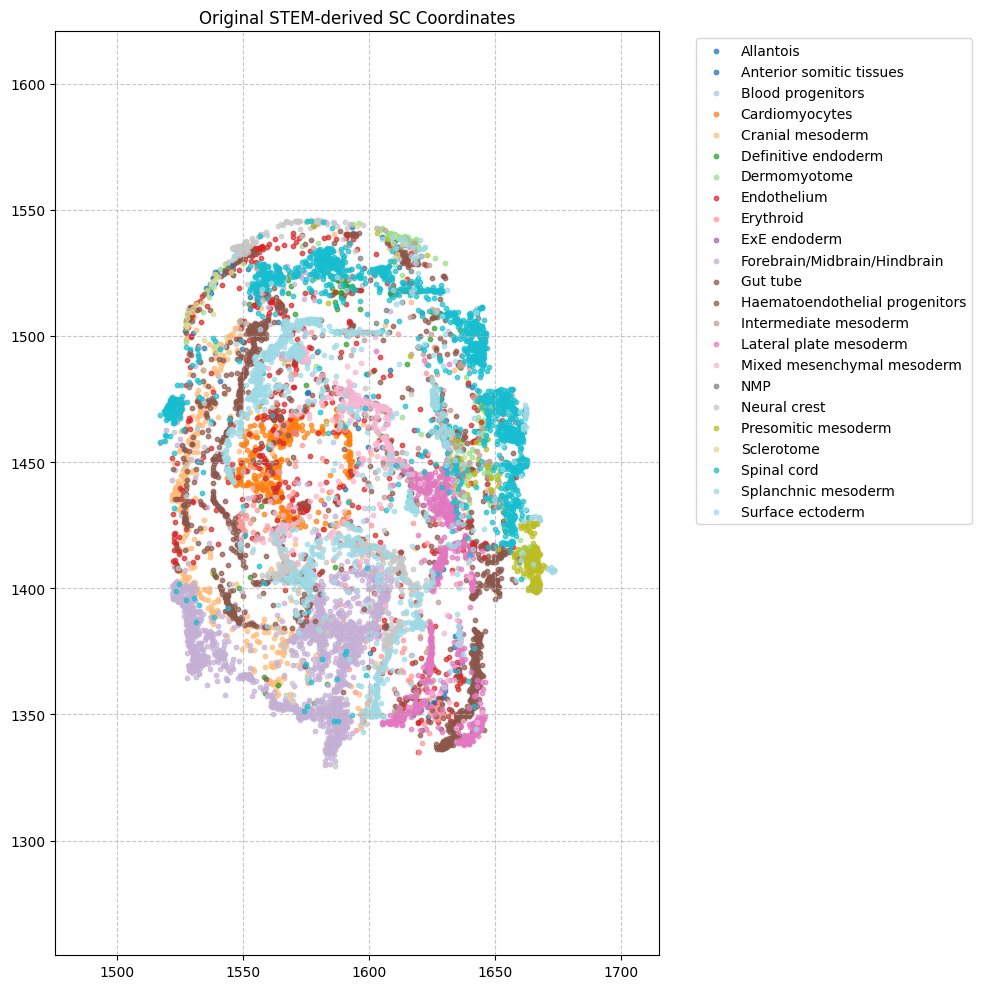

In [20]:
def plot_stem_coordinates():
    # Get the original SC coordinates from the STEM model
    stem_sc_coords = adata.obsm['spatialDA']
    
    # Plot
    plt.figure(figsize=(10, 10))
    
    # You can color by cell type if available
    if 'celltype_mapped_refined' in adata.obs.columns:
        cell_types = adata.obs['celltype_mapped_refined'].values
        unique_types = np.unique(cell_types)
        cmap = plt.cm.get_cmap('tab20', len(unique_types))
        
        for i, cell_type in enumerate(unique_types):
            mask = cell_types == cell_type
            plt.scatter(
                stem_sc_coords[mask, 0], 
                stem_sc_coords[mask, 1], 
                c=[cmap(i)], 
                label=cell_type, 
                alpha=0.7, 
                s=10
            )
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        plt.scatter(stem_sc_coords[:, 0], stem_sc_coords[:, 1], alpha=0.7, s=10)
    
    plt.title('Original STEM-derived SC Coordinates')
    plt.axis('equal')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    # plt.savefig('stem_sc_coordinates.png', dpi=300, bbox_inches='tight')
    plt.show()

# Call the function
plot_stem_coordinates()

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
import os

class SinusoidalEmbedding(nn.Module):
    """Sinusoidal embeddings for diffusion timesteps (more stable than linear)"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, t):
        """
        Args:
            t: timesteps [batch_size, 1]
        Returns:
            embeddings [batch_size, dim]
        """
        half_dim = self.dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t * emb[None, :]
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        
        # If dim is odd, pad with zeros
        if self.dim % 2 == 1:
            emb = F.pad(emb, (0, 1, 0, 0))
        return emb

class ResidualBlock(nn.Module):
    """Residual block for better gradient flow"""
    def __init__(self, in_dim, hidden_dim=None):
        super().__init__()
        hidden_dim = hidden_dim or in_dim
        self.block1 = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.SiLU()
        )
        self.block2 = nn.Sequential(
            nn.Linear(hidden_dim, in_dim),
            nn.LayerNorm(in_dim),
        )
        self.activation = nn.SiLU()
    
    def forward(self, x):
        h = self.block1(x)
        h = self.block2(h)
        return self.activation(x + h)

class CoordinatePredictor(nn.Module):
    """Enhanced model to predict coordinates conditioned on gene expression and timestep"""
    def __init__(self, feature_dim, hidden_dim=256, depth=4):
        super().__init__()
        self.time_embed = nn.Sequential(
            SinusoidalEmbedding(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # Feature embedding network
        self.feature_embed = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.SiLU()
        )
        
        # Coordinate embedding
        self.coord_encoder = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.SiLU()
        )
        
        # Main network with residual blocks
        self.blocks = nn.ModuleList([
            ResidualBlock(hidden_dim * 3, hidden_dim * 2)
        ])
        for _ in range(depth - 1):
            self.blocks.append(ResidualBlock(hidden_dim * 3, hidden_dim * 2))
        
        # Output layer
        self.output = nn.Sequential(
            nn.Linear(hidden_dim * 3, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 2)  # Predict noise for x, y coordinates
        )
    
    def forward(self, coords, t, features):
        """
        Args:
            coords: Noisy coordinates [batch_size, 2]
            t: Diffusion timestep [batch_size, 1]
            features: Gene expression features [batch_size, feature_dim]
        Returns:
            Predicted noise [batch_size, 2]
        """
        # Get embeddings
        t_emb = self.time_embed(t)
        feat_emb = self.feature_embed(features)
        coord_emb = self.coord_encoder(coords)
        
        # Concatenate embeddings
        h = torch.cat([t_emb, feat_emb, coord_emb], dim=1)
        
        # Apply residual blocks
        for block in self.blocks:
            h = block(h)
        
        # Predict noise
        return self.output(h)

class STDataset(Dataset):
    """Dataset for ST data with known coordinates"""
    def __init__(self, gene_expression, coordinates):
        """
        Args:
            gene_expression: Gene expression data [n_samples, n_genes]
            coordinates: Spatial coordinates [n_samples, 2]
        """
        self.gene_expression = torch.tensor(gene_expression, dtype=torch.float32)
        self.coordinates = torch.tensor(coordinates, dtype=torch.float32)
        
    def __len__(self):
        return len(self.coordinates)
    
    def __getitem__(self, idx):
        return {
            'gene_expression': self.gene_expression[idx],
            'coordinates': self.coordinates[idx]
        }

class CoordinateDiffusion:
    """Diffusion model for inferring coordinates from gene expression data"""
    def __init__(self, st_gene_expr, st_coords, sc_gene_expr, sc_embeddings, device=None):
        self.device = self._get_device(device)
        
        # Normalize coordinates to [-1, 1] range for better training stability
        self.st_coords_min = np.min(st_coords, axis=0)
        self.st_coords_max = np.max(st_coords, axis=0)
        self.st_coords_normalized = self._normalize_coordinates(st_coords)
        
        # ST data (with known coordinates for training)
        self.st_gene_expr = torch.tensor(st_gene_expr, dtype=torch.float32).to(self.device)
        self.st_coords = torch.tensor(self.st_coords_normalized, dtype=torch.float32).to(self.device)
        
        # SC data (for inference)
        self.sc_gene_expr = torch.tensor(sc_gene_expr, dtype=torch.float32).to(self.device)
        
        # SC embeddings (from STEM model)
        if isinstance(sc_embeddings, torch.Tensor):
            self.sc_embeddings = sc_embeddings.to(self.device)
        else:
            self.sc_embeddings = torch.tensor(sc_embeddings, dtype=torch.float32).to(self.device)
        
        # Calculate adjacency matrices for ST data
        self.st_distances = self._calculate_distances(self.st_coords)
        self.st_adjacency = self._calculate_adjacency_from_distances(self.st_distances)
        
        # Model dimensions
        self.n_st_samples = self.st_gene_expr.shape[0]
        self.n_sc_samples = self.sc_gene_expr.shape[0]
        self.n_genes = self.st_gene_expr.shape[1]
        
        # Setup model with increased capacity and learning rate
        self.model = CoordinatePredictor(self.n_genes, hidden_dim=512, depth=6).to(self.device)
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=2e-4, weight_decay=1e-5)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=200, gamma=0.7)
        
        # Create ST dataset and loader
        self.st_dataset = STDataset(st_gene_expr, self.st_coords_normalized)
    
    def _normalize_coordinates(self, coords):
        """Normalize coordinates to [-1, 1] range"""
        coords_range = self.st_coords_max - self.st_coords_min
        normalized = 2 * (coords - self.st_coords_min) / coords_range - 1
        return normalized
    
    def _denormalize_coordinates(self, normalized_coords):
        """Convert normalized coordinates back to original space"""
        coords_range = self.st_coords_max - self.st_coords_min
        return (normalized_coords + 1) / 2 * coords_range + self.st_coords_min
    
    def _get_device(self, device):
        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        return torch.device(device)
    
    def _calculate_distances(self, coords):
        """Calculate pairwise distances between coordinates"""
        if isinstance(coords, torch.Tensor):
            return torch.cdist(coords, coords, p=2)
        else:
            coords_tensor = torch.tensor(coords, dtype=torch.float32).to(self.device)
            return torch.cdist(coords_tensor, coords_tensor, p=2)
    
    def _calculate_adjacency_from_distances(self, distances, sigma=0.1):
        """Convert distances to adjacency matrix using Gaussian kernel
        
        Using smaller sigma for normalized coordinates in [-1, 1] range
        """
        weights = torch.exp(-(distances ** 2) / (2 * sigma ** 2))
        # Zero out self-connections to avoid numerical issues
        identity_mask = torch.eye(weights.shape[0], device=weights.device)
        weights = weights * (1 - identity_mask)
        # Normalize rows to sum to 1
        row_sums = weights.sum(dim=1, keepdim=True)
        adjacency = weights / (row_sums + 1e-8)  # add small epsilon for numerical stability
        return adjacency
    
    def get_noise_schedule(self, timesteps=1000, beta1=1e-4, beta2=0.02):
        """Returns DDPM noise schedule parameters"""
        # Linear schedule
        betas = torch.linspace(beta1, beta2, timesteps, device=self.device)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
        sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
        
        # Fix posterior variance calculation - the sizes need to match
        posterior_variance = torch.zeros_like(betas)
        posterior_variance[1:] = betas[1:] * (1. - alphas_cumprod[:-1]) / (1. - alphas_cumprod[1:])
        posterior_variance[0] = betas[0]  # Special case for the first step
        
        return {
            'betas': betas,
            'alphas': alphas,
            'alphas_cumprod': alphas_cumprod,
            'sqrt_alphas_cumprod': sqrt_alphas_cumprod,
            'sqrt_one_minus_alphas_cumprod': sqrt_one_minus_alphas_cumprod,
            'posterior_variance': posterior_variance
        }
    
    def add_noise(self, x_0, t, noise_schedule):
        """Add noise to coordinates according to timestep t"""
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = noise_schedule['sqrt_alphas_cumprod'][t].view(-1, 1)
        sqrt_one_minus_alphas_cumprod_t = noise_schedule['sqrt_one_minus_alphas_cumprod'][t].view(-1, 1)
        
        # Add noise according to schedule
        x_t = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise
        
        return x_t, noise
    
    def train(self, n_epochs=2000, batch_size=64, timesteps=500, beta1=1e-4, beta2=0.02, 
            lambda_structure_start=10.0, lambda_structure_end=50.0, save_every=100, 
            checkpoint_dir="./checkpoints"):
        """Train the diffusion model on ST data with improved loss balancing"""
        os.makedirs(checkpoint_dir, exist_ok=True)
        
        # Setup noise schedule
        noise_schedule = self.get_noise_schedule(timesteps, beta1, beta2)
        
        # Dataloader for ST data
        dataloader = DataLoader(self.st_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
        
        # Change the scheduler to a simple step decay
        self.scheduler = torch.optim.lr_scheduler.StepLR(
            self.optimizer, step_size=200, gamma=0.7
        )
        
        # Training metrics
        diffusion_losses = []
        structure_losses = []
        total_losses = []
        
        self.model.train()
        for epoch in range(n_epochs):
            epoch_diffusion_loss = 0
            epoch_structure_loss = 0
            epoch_total_loss = 0
            
            for batch in dataloader:
                gene_expr = batch['gene_expression'].to(self.device)
                coords = batch['coordinates'].to(self.device)
                
                # Sample random timesteps
                t = torch.randint(0, timesteps, (coords.shape[0],), device=self.device)
                
                # Add noise to coordinates
                noisy_coords, noise = self.add_noise(coords, t, noise_schedule)
                
                # Predict noise
                predicted_noise = self.model(noisy_coords, t.unsqueeze(1).float() / timesteps, gene_expr)
                
                # Diffusion loss (MSE between predicted and actual noise)
                diffusion_loss = F.mse_loss(predicted_noise, noise)
                
                # One-step denoising to get estimated coordinates
                sqrt_alphas_cumprod_t = noise_schedule['sqrt_alphas_cumprod'][t].view(-1, 1)
                sqrt_one_minus_alphas_cumprod_t = noise_schedule['sqrt_one_minus_alphas_cumprod'][t].view(-1, 1)
                
                # Estimate the clean coordinates using the predicted noise
                pred_coords = (noisy_coords - sqrt_one_minus_alphas_cumprod_t * predicted_noise) / sqrt_alphas_cumprod_t
                
                # Calculate adjacency matrices
                pred_adjacency = self._calculate_adjacency_from_distances(torch.cdist(pred_coords, pred_coords, p=2))
                true_adjacency = self._calculate_adjacency_from_distances(torch.cdist(coords, coords, p=2))
                
                # Structure loss - KL divergence for probability distributions
                eps = 1e-8  # prevent log(0)
                structure_loss = F.kl_div(
                    torch.log(pred_adjacency + eps),
                    true_adjacency,
                    reduction='batchmean'
                )
                
                # Progressive lambda adjustment - smooth transition from focusing on diffusion to structure
                if epoch < n_epochs * 0.1:  # First 10% - warmup phase
                    current_lambda = 0.1 * lambda_structure_start
                else:
                    # Gradually increase lambda from start to end value
                    progress = (epoch - n_epochs * 0.1) / (n_epochs * 0.9)
                    current_lambda = lambda_structure_start + progress * (lambda_structure_end - lambda_structure_start)
                
                # Total loss
                total_loss = diffusion_loss + current_lambda * structure_loss
                
                # Backpropagation
                self.optimizer.zero_grad()
                total_loss.backward()
                
                # Gradient clipping for stability
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                
                self.optimizer.step()
                
                # Accumulate losses
                epoch_diffusion_loss += diffusion_loss.item()
                epoch_structure_loss += structure_loss.item()
                epoch_total_loss += total_loss.item()
            
            # Step scheduler
            self.scheduler.step()
            
            # Average losses over batches
            n_batches = len(dataloader)
            epoch_diffusion_loss /= n_batches
            epoch_structure_loss /= n_batches
            epoch_total_loss /= n_batches
            
            # Store metrics
            diffusion_losses.append(epoch_diffusion_loss)
            structure_losses.append(epoch_structure_loss)
            total_losses.append(epoch_total_loss)
            
            # Print progress with current lambda value
            if (epoch + 1) % (n_epochs // 20) == 0 or epoch == 0:
                print(f"Epoch {epoch+1}/{n_epochs}, "
                    f"Diffusion Loss: {epoch_diffusion_loss:.6f}, "
                    f"Structure Loss: {epoch_structure_loss:.6f}, "
                    f"Total Loss: {epoch_total_loss:.6f}, "
                    f"Lambda: {current_lambda:.2f}, "
                    f"LR: {self.scheduler.get_last_lr()[0]:.6f}")
                        
            # Save checkpoint
            if (epoch + 1) % save_every == 0:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'scheduler_state_dict': self.scheduler.state_dict(),
                    'diffusion_loss': epoch_diffusion_loss,
                    'structure_loss': epoch_structure_loss,
                    'total_loss': epoch_total_loss,
                    'coords_min': self.st_coords_min,
                    'coords_max': self.st_coords_max,
                }, f"{checkpoint_dir}/model_epoch_{epoch+1}.pt")
                
                # Plot and save losses
                self.plot_losses(diffusion_losses, structure_losses, total_losses, 
                                 save_path=f"{checkpoint_dir}/losses_epoch_{epoch+1}.png")
                
                # Generate and save sample coordinates
                if (epoch + 1) % (save_every * 5) == 0:
                    # Sample a small batch of SC data for quick visualization
                    sample_size = min(200, self.n_sc_samples)
                    sample_indices = np.random.choice(self.n_sc_samples, sample_size, replace=False)
                    sample_gene_expr = self.sc_gene_expr[sample_indices]
                    sample_coords = self.sample_coordinates(sample_gene_expr, timesteps=100)
                    
                    # Denormalize and visualize
                    sample_coords_denorm = self._denormalize_coordinates(sample_coords)
                    self.visualize_coordinates(
                        sample_coords_denorm, 
                        title=f"Generated SC Coordinates (Epoch {epoch+1})",
                        save_path=f"{checkpoint_dir}/sample_coords_epoch_{epoch+1}.png"
                    )
        
        # Final checkpoint
        torch.save({
            'epoch': n_epochs,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'diffusion_loss': epoch_diffusion_loss,
            'structure_loss': epoch_structure_loss,
            'total_loss': epoch_total_loss,
            'coords_min': self.st_coords_min,
            'coords_max': self.st_coords_max,
        }, f"{checkpoint_dir}/model_final.pt")
        
        # Final loss plot
        self.plot_losses(diffusion_losses, structure_losses, total_losses, 
                         save_path=f"{checkpoint_dir}/losses_final.png")
        
        return {
            'diffusion_losses': diffusion_losses,
            'structure_losses': structure_losses,
            'total_losses': total_losses
        }
    
    def plot_losses(self, diffusion_losses, structure_losses, total_losses, save_path=None):
        """Plot training losses"""
        plt.figure(figsize=(12, 8))
        
        # Plot losses on separate subplots for clarity
        plt.subplot(2, 1, 1)
        plt.plot(diffusion_losses, label='Diffusion Loss')
        plt.yscale('log')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (log scale)')
        plt.title('Diffusion Loss')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        
        plt.subplot(2, 1, 2)
        plt.plot(structure_losses, label='Structure Loss', color='orange')
        plt.plot(total_losses, label='Total Loss', color='green', linestyle='--')
        plt.yscale('log')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (log scale)')
        plt.title('Structure & Total Loss')
        plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
            plt.close()
        else:
            plt.show()
    
    @torch.no_grad()
    def sample_coordinates(self, gene_expr, timesteps=1000, batch_size=None):
        """Sample coordinates for given gene expression data"""
        self.model.eval()
        
        # Handle input as tensor or ndarray
        if not isinstance(gene_expr, torch.Tensor):
            gene_expr = torch.tensor(gene_expr, dtype=torch.float32).to(self.device)
        
        # Get noise schedule
        noise_schedule = self.get_noise_schedule(timesteps)
        
        # Process all at once if batch_size is None or larger than the data
        if batch_size is None or batch_size >= gene_expr.shape[0]:
            # Start with random noise
            x = torch.randn(gene_expr.shape[0], 2, device=self.device)
            
            # Reverse diffusion process
            for t in tqdm(range(timesteps - 1, -1, -1), desc="Sampling coordinates"):
                # Create timestep tensor
                time_t = torch.ones(gene_expr.shape[0], 1, device=self.device) * t / timesteps
                
                # Predict noise
                predicted_noise = self.model(x, time_t, gene_expr)
                
                # No noise for the last step
                if t > 0:
                    noise = torch.randn_like(x)
                else:
                    noise = 0
                
                # Get parameters for this timestep
                alpha_t = noise_schedule['alphas'][t]
                alpha_cumprod_t = noise_schedule['alphas_cumprod'][t]
                beta_t = noise_schedule['betas'][t]
                
                # Update sample with reverse diffusion step
                x = (1 / torch.sqrt(alpha_t)) * (x - (1 - alpha_t) / torch.sqrt(1 - alpha_cumprod_t) * predicted_noise)
                if t > 0:
                    x = x + torch.sqrt(beta_t) * noise
            
            return x.cpu().numpy()
        
        # Process in batches otherwise
        else:
            all_coords = []
            for i in range(0, gene_expr.shape[0], batch_size):
                end_idx = min(i + batch_size, gene_expr.shape[0])
                batch_gene_expr = gene_expr[i:end_idx]
                
                # Start with random noise
                x = torch.randn(end_idx - i, 2, device=self.device)
                
                # Reverse diffusion process
                for t in tqdm(range(timesteps - 1, -1, -1), desc=f"Sampling batch {i//batch_size + 1}"):
                    # Create timestep tensor
                    time_t = torch.ones(end_idx - i, 1, device=self.device) * t / timesteps
                    
                    # Predict noise
                    predicted_noise = self.model(x, time_t, batch_gene_expr)
                    
                    # No noise for the last step
                    if t > 0:
                        noise = torch.randn_like(x)
                    else:
                        noise = 0
                    
                    # Get parameters for this timestep
                    alpha_t = noise_schedule['alphas'][t]
                    alpha_cumprod_t = noise_schedule['alphas_cumprod'][t]
                    beta_t = noise_schedule['betas'][t]
                    
                    # Update sample with reverse diffusion step
                    x = (1 / torch.sqrt(alpha_t)) * (x - (1 - alpha_t) / torch.sqrt(1 - alpha_cumprod_t) * predicted_noise)
                    if t > 0:
                        x = x + torch.sqrt(beta_t) * noise
                
                all_coords.append(x.cpu().numpy())
            
            return np.concatenate(all_coords, axis=0)
    
    @torch.no_grad()
    def sample_sc_coordinates(self, timesteps=1000, batch_size=100):
        """Generate coordinates for all SC data"""
        # Sample coordinates using SC gene expression
        sc_coords_normalized = self.sample_coordinates(
            self.sc_gene_expr, timesteps=timesteps, batch_size=batch_size
        )
        
        # Denormalize coordinates to original scale
        sc_coords = self._denormalize_coordinates(sc_coords_normalized)
        
        return sc_coords
    
    def visualize_coordinates(self, coordinates, gene_expr=None, title="Spatial Coordinates", 
                             color_by=None, save_path=None):
        """Visualize generated coordinates with optional coloring by gene expression"""
        plt.figure(figsize=(10, 10))
        
        if color_by is not None and gene_expr is not None:
            # Color by specified gene or feature
            if isinstance(color_by, int):
                color_values = gene_expr[:, color_by]
            elif isinstance(color_by, str) and color_by == 'cluster':
                # Perform clustering on gene expression
                from sklearn.cluster import KMeans
                kmeans = KMeans(n_clusters=8, random_state=42)
                color_values = kmeans.fit_predict(gene_expr)
            else:
                color_values = None
                
            if color_values is not None:
                scatter = plt.scatter(coordinates[:, 0], coordinates[:, 1], c=color_values, 
                                     cmap='viridis', alpha=0.8, s=10)
                plt.colorbar(scatter, label=f"Gene {color_by}" if isinstance(color_by, int) else "Cluster")
            else:
                plt.scatter(coordinates[:, 0], coordinates[:, 1], alpha=0.8, s=10)
        else:
            plt.scatter(coordinates[:, 0], coordinates[:, 1], alpha=0.8, s=10)
        
        plt.title(title)
        plt.axis('equal')
        plt.grid(True, linestyle='--', alpha=0.7)
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            plt.close()
        else:
            plt.show()
    
    def load_checkpoint(self, checkpoint_path):
        """Load model from checkpoint"""
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if 'scheduler_state_dict' in checkpoint:
            self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        if 'coords_min' in checkpoint and 'coords_max' in checkpoint:
            self.st_coords_min = checkpoint['coords_min']
            self.st_coords_max = checkpoint['coords_max']
        print(f"Loaded checkpoint from {checkpoint_path} (epoch {checkpoint['epoch']})")
        return checkpoint

# Example usage:
# 1. Load data and compute embeddings using STEM
stdata = pd.read_csv('data/mousedata_2020/E1z2/simu_st_counts.csv', index_col=0).T
scdata = pd.read_csv('data/mousedata_2020/E1z2/simu_sc_counts.csv', index_col=0).T
spcoor = pd.read_csv('data/mousedata_2020/E1z2/simu_st_metadata.csv', index_col=0)

# Preprocess data (normalize, log transform)
adata = sc.AnnData(scdata, obs=scmetadata)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
scdata_processed = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)

stadata = sc.AnnData(stdata)
sc.pp.normalize_total(stadata)
sc.pp.log1p(stadata)
stdata_processed = pd.DataFrame(stadata.X, index=stadata.obs_names, columns=stadata.var_names)

# Get STEM embeddings
testmodel = SOmodel(opt)
testmodel = testmodel.to('cuda')
testmodel.load()  # Load pre-trained STEM model
testmodel.modeleval()
scembedding = testmodel.netE(torch.tensor(scdata_processed.values, dtype=torch.float32).cuda())
stembedding = testmodel.netE(torch.tensor(stdata_processed.values, dtype=torch.float32).cuda())
scembedding_np = scembedding.detach().cpu().numpy()
stembedding_np = stembedding.detach().cpu().numpy()

# 2. Initialize and train the diffusion model
diffusion = CoordinateDiffusion(
    st_gene_expr=stdata_processed.values,
    st_coords=spcoor.values,
    sc_gene_expr=scdata_processed.values,
    sc_embeddings=scembedding_np,
    device="cuda"
)

# 3. Train the model
# losses = diffusion.train(
#     n_epochs=2000,
#     batch_size=64,  # Larger batch size for stability
#     timesteps=500,
#     lambda_structure=100.0,  # Significantly higher weight for structure loss
#     save_every=100
# )

losses = diffusion.train(
    n_epochs=2000,
    batch_size=64,
    timesteps=500,
    lambda_structure_start=5.0,    # Start with a smaller value
    lambda_structure_end=20.0,     # End with a moderate value
    save_every=100
)

# 4. Generate coordinates for SC data
sc_coords = diffusion.sample_sc_coordinates(timesteps=200)  # Fewer timesteps for faster sampling

# 5. Visualize the results
diffusion.visualize_coordinates(sc_coords, scdata_processed.values, 
                                title="Generated SC Coordinates", 
                                color_by="cluster", 
                                save_path="new_sc_coordinates_v2.png")

===> Loading model from log/Mouse_E1z2/model.pth
<=== Success!
Epoch 1/2000, Diffusion Loss: 1.759247, Structure Loss: 14.679179, Total Loss: 9.098836, Lambda: 0.50, LR: 0.000200
Epoch 100/2000, Diffusion Loss: 0.257557, Structure Loss: 9.105986, Total Loss: 4.810550, Lambda: 0.50, LR: 0.000200
Epoch 200/2000, Diffusion Loss: 0.111235, Structure Loss: 6.538152, Total Loss: 3.380311, Lambda: 0.50, LR: 0.000140
Epoch 300/2000, Diffusion Loss: 0.127997, Structure Loss: 4.927600, Total Loss: 28.831266, Lambda: 5.83, LR: 0.000140
Epoch 400/2000, Diffusion Loss: 0.230112, Structure Loss: 2.798672, Total Loss: 18.864603, Lambda: 6.66, LR: 0.000098
Epoch 500/2000, Diffusion Loss: 0.115612, Structure Loss: 2.378948, Total Loss: 17.937897, Lambda: 7.49, LR: 0.000098


Sampling coordinates: 100%|██████████| 100/100 [00:00<00:00, 518.43it/s]


Epoch 600/2000, Diffusion Loss: 0.069139, Structure Loss: 1.875802, Total Loss: 15.685191, Lambda: 8.32, LR: 0.000069
Epoch 700/2000, Diffusion Loss: 0.072454, Structure Loss: 1.989613, Total Loss: 18.293990, Lambda: 9.16, LR: 0.000069
Epoch 800/2000, Diffusion Loss: 0.048613, Structure Loss: 0.610384, Total Loss: 6.147366, Lambda: 9.99, LR: 0.000048
Epoch 900/2000, Diffusion Loss: 0.025031, Structure Loss: 0.677455, Total Loss: 7.358484, Lambda: 10.82, LR: 0.000048
Epoch 1000/2000, Diffusion Loss: 0.056590, Structure Loss: 0.417503, Total Loss: 4.923982, Lambda: 11.66, LR: 0.000034


Sampling coordinates: 100%|██████████| 100/100 [00:00<00:00, 728.76it/s]


Epoch 1100/2000, Diffusion Loss: 0.029672, Structure Loss: 0.731310, Total Loss: 9.164956, Lambda: 12.49, LR: 0.000034
Epoch 1200/2000, Diffusion Loss: 0.042954, Structure Loss: 0.595954, Total Loss: 7.984039, Lambda: 13.33, LR: 0.000024
Epoch 1300/2000, Diffusion Loss: 0.040504, Structure Loss: 0.214365, Total Loss: 3.075558, Lambda: 14.16, LR: 0.000024
Epoch 1400/2000, Diffusion Loss: 0.041724, Structure Loss: 0.158797, Total Loss: 2.422361, Lambda: 14.99, LR: 0.000016
Epoch 1500/2000, Diffusion Loss: 0.017171, Structure Loss: 0.087117, Total Loss: 1.395790, Lambda: 15.82, LR: 0.000016


Sampling coordinates: 100%|██████████| 100/100 [00:00<00:00, 694.88it/s]


Epoch 1600/2000, Diffusion Loss: 0.016982, Structure Loss: 0.157998, Total Loss: 2.648966, Lambda: 16.66, LR: 0.000012
Epoch 1700/2000, Diffusion Loss: 0.014585, Structure Loss: 0.129156, Total Loss: 2.273747, Lambda: 17.49, LR: 0.000012
Epoch 1800/2000, Diffusion Loss: 0.012068, Structure Loss: 0.067284, Total Loss: 1.245042, Lambda: 18.32, LR: 0.000008
Epoch 1900/2000, Diffusion Loss: 0.026162, Structure Loss: 0.067027, Total Loss: 1.310279, Lambda: 19.16, LR: 0.000008
Epoch 2000/2000, Diffusion Loss: 0.013681, Structure Loss: 0.041867, Total Loss: 0.850665, Lambda: 19.99, LR: 0.000006


Sampling batch 102: 100%|██████████| 200/200 [00:00<00:00, 692.54it/s]


In [ ]:
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

# Saliency Map

In [ ]:
sc.settings.figdir = './result_E1z2/'

## Spinalcoord

In [ ]:
spinalcoorddata = scdata[(scmetadata['celltype_mapped_refined']=='Spinal cord')&(scmetadata.y_global>1410)].copy()
spinalcoorddata = torch.Tensor(spinalcoorddata.values).cuda()

spinalmetadata = scmetadata[scmetadata['celltype_mapped_refined']=='Spinal cord']
spinalmetadata = spinalmetadata[spinalmetadata.y_global>1410]

spinaladata = adata[(scmetadata['celltype_mapped_refined']=='Spinal cord')&(scmetadata.y_global>1410),:].copy()

In [ ]:
def curve_length(x,y):
    x = np.linspace(0, y-x, 100)
    curve = a5*x**5+a4*x**4 + a3*x**3 + a2*x**2 +a1*x+a0
    return np.sum(np.sqrt(np.sum((curve[:-1] - curve[1:])**2,axis=1)))

In [ ]:
spinalspcoor =  spinaladata.obsm['spatial']

a5,a4, a3,a2,a1,a0= np.polyfit(spinalspcoor[:,0],spinalspcoor[:,1],5)
fity = a5*spinalspcoor[:,0]**5+a4*spinalspcoor[:,0]**4 + a3*spinalspcoor[:,0]**3 + a2*spinalspcoor[:,0]**2 +a1*spinalspcoor[:,0]+a0

pseudotime = []
for i in range(spinalspcoor.shape[0]):
    pseudotime.append(curve_length(spinalspcoor[0,:],spinalspcoor[i,:]))

pseudotime = np.array(pseudotime)/1e8
pseudotime = (pseudotime.max() - pseudotime)/(pseudotime.max()-pseudotime.min())
# plt.savefig('nipsfig/embro_spinal_traj.png',bbox_inches='tight',dpi=330)
spinaladata.obs['pseudotime'] = pseudotime
spinaladata.obsm['pseudotime'] = np.expand_dims(np.array(pseudotime),1)

In [ ]:
sc.pl.spatial(spinaladata,color='pseudotime',spot_size=2,basis='spatial')

In [ ]:
sc.pp.neighbors(spinaladata,use_rep='pseudotime')
sc.tl.leiden(spinaladata,resolution=0.1)

In [ ]:
figsize(4,5)
sc.pl.spatial(spinaladata,color='leiden',spot_size=2,save='segments')

In [ ]:
class Captummodel(nn.Module):
    def __init__(self, netE, stembedding):
        super(Captummodel, self).__init__()

        self.netE = netE
        self.netE.eval()
        self.stembedding = stembedding.t()

    def forward(self, x):
        x = self.netE(x)
        return x.mm(self.stembedding)
from captum.attr import IntegratedGradients

In [ ]:
from tqdm import tqdm
capt = Captummodel(testmodel.netE,stembedding.detach())
capt.eval()


allsali = []
allbestidx = []
alldelta = []
allscemb = []
for i in tqdm(range(spinalcoorddata.shape[0])):
    inputdata = spinalcoorddata[i].unsqueeze(0)
    scembedding = testmodel.netE(inputdata)
    allscemb.append(scembedding.detach().cpu().numpy())
    spinal2st = scembedding.mm(stembedding.detach().t())
    idx = spinal2st.argmax()
    ig = IntegratedGradients(capt)
    attributions,delta = ig.attribute(inputdata,target=idx,return_convergence_delta=True)
    allsali.append(attributions.detach().cpu().numpy()[0])
    alldelta.append(delta.mean().item())
allsali = np.array(allsali)

In [ ]:
saliadata = sc.AnnData(pd.DataFrame(allsali,columns=scdata.columns,index = spinaladata.obs_names),obs = spinaladata.obs)
saliadata.obsm['spatial'] = spinaladata.obsm['spatial']
saliadata.obsm['spatialDA'] = spinaladata.obsm['spatialDA']

In [ ]:
sc.tl.rank_genes_groups(saliadata,groupby='leiden',method='wilcoxon')

In [ ]:
sc.get.rank_genes_groups_df(saliadata,pval_cutoff =0.05,log2fc_min=0,group=None).names.unique().shape

In [ ]:
maxclt = saliadata.obs['leiden'].values.astype(int).max()
clusteridx =[]
for i in range(maxclt+1):
    clusteridx.append(saliadata.obs.loc[saliadata.obs['leiden']==str(i),'pseudotime'].mean())

a = np.arange(maxclt+1)
reclusterindex = [a for _,a in sorted(zip(clusteridx,a))]

In [ ]:
import seaborn as sns
rkgene = pd.DataFrame(saliadata.uns['rank_genes_groups']['names'])
cellorder = saliadata.obs.sort_values('pseudotime').index
salidf = pd.DataFrame(saliadata[cellorder,:].X,index=saliadata[cellorder,:].obs.pseudotime.tolist(),columns=saliadata.var_names)

N=4
topgenelist = []
for i in reclusterindex:
    topgenelist += rkgene.iloc[:N,i].tolist()

sal_plotgenelist=[]
for x in topgenelist:
    if x not in sal_plotgenelist:
        sal_plotgenelist.append(x)
df = salidf.loc[:,sal_plotgenelist].T

In [ ]:
plotsali = saliadata[cellorder,:].copy()
sc.pp.scale(plotsali)

In [ ]:
sc.pl.heatmap(plotsali,df.index.tolist(),groupby='pseudotime',cmap='bwr',swap_axes=False,standard_scale='obs',figsize=(9,2),save='spinal_traj_axis.pdf')

In [ ]:
import matplotlib.colors as colors
figsize(3.8,3)
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['axes.spines.left'] = False
rcParams['axes.spines.bottom'] = False
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
sc.pl.spatial(spinaladata,spot_size=3,color=['Marcks','Hoxb5','Sfrp1','Pcdh19','Hoxb1','Mesp2'],ncols=6,basis='spatial',save='trajectory_exrpession.pdf')

In [ ]:
sc.pl.spatial(spinaladata,spot_size=3,color=['Marcks','Hoxb5','Sfrp1','Pcdh19','Hoxb1','Mesp2'],cmap='coolwarm',ncols=6,basis='spatial')

In [ ]:
figsize(3.8,2.8)
rcParams['axes.spines.left'] = True
rcParams['axes.spines.bottom'] = True
sc.pl.spatial(spinaladata,spot_size=3,color=['Nebl','Bak1','Kmt2d','Suz12','Fgfr2'],ncols=6,cmap='coolwarm',basis='spatial',save='nonspatialsdg.pdf')
sc.pl.spatial(saliadata,spot_size=2,color=['Nebl','Bak1','Kmt2d','Suz12','Fgfr2'],ncols=6,cmap='coolwarm',basis='spatial',norm = colors.SymLogNorm(linthresh=0.001,base=10),save='nonspatialsdg-saliency.pdf')

## Forebrain/Midbrain/Hindbrain

In [ ]:
spinaladata = adata[scmetadata['celltype_mapped_refined']=='Forebrain/Midbrain/Hindbrain',:].copy()
spinaladata = spinaladata[spinaladata.obs['y_global']<1430].copy()
spinaladata = spinaladata[spinaladata.obs['x_global']<1630].copy()

sc.pp.neighbors(spinaladata,use_rep='spatial')
sc.tl.leiden(spinaladata,resolution=0.5)
sc.pl.spatial(spinaladata,color='leiden',spot_size=2,basis='spatial') 

In [ ]:

spinaladata.obs['name'] = spinaladata.obs['leiden'].copy().astype(str)
spinaladata.obs.loc[spinaladata.obs['leiden']=='0','name'] ='Hindbrain'
spinaladata.obs.loc[spinaladata.obs['leiden']=='1','name'] ='Midbrain'
spinaladata.obs.loc[spinaladata.obs['leiden']=='2','name'] ='Hindbrain'
spinaladata.obs.loc[spinaladata.obs['leiden']=='3','name'] ='Forebrain'
spinaladata.obs.loc[spinaladata.obs['leiden']=='4','name'] ='Forebrain'
spinaladata.obs.loc[spinaladata.obs['leiden']=='5','name'] ='Forebrain'
spinaladata.obs.loc[spinaladata.obs['leiden']=='6','name'] ='Forebrain'
spinaladata.obs.loc[spinaladata.obs['leiden']=='7','name'] ='Forebrain'
spinaladata.obs.loc[spinaladata.obs['leiden']=='8','name'] ='Midbrain'
spinaladata.obs.loc[spinaladata.obs['leiden']=='9','name'] ='Tegmentum'
spinaladata.obs.loc[spinaladata.obs['leiden']=='10','name'] ='Tegmentum'
figsize(4,4)
sc.pl.spatial(spinaladata,color='name',spot_size=2,basis='spatial',save='embro_brainsep') 

In [ ]:
# spinaladata = spinaladata[spinaladata.obs.name.isin(['Midbrain','Tegmentum']),:]
spinalcoorddata = np.array(spinaladata.X)
spinalmetadata = spinaladata.obs

In [ ]:
from tqdm import tqdm
capt = Captummodel(testmodel.netE,stembedding.detach())
capt.eval()
spinalcoorddata = torch.Tensor(spinalcoorddata).cuda()

allsali = []
allbestidx = []
alldelta = []
allemb=[]
for i in tqdm(range(spinalcoorddata.shape[0])):
    inputdata = spinalcoorddata[i].unsqueeze(0)
    scembedding = testmodel.netE(inputdata)
    allemb.append(scembedding.detach().cpu().numpy())
    spinal2st = scembedding.mm(stembedding.detach().t())
    idx = spinal2st.argmax()
    ig = IntegratedGradients(capt)
    attributions,delta = ig.attribute(inputdata,target=idx,return_convergence_delta=True)
    # attributions, delta = nt.attribute(inputdata,baselines= torch.rand_like(inputdata)*0.01,nt_type='smoothgrad', stdevs=0.02, nt_samples=5, target=idx, return_convergence_delta=True)
    allsali.append(attributions.detach().cpu().numpy()[0])
    alldelta.append(delta.mean().item())

allsali = np.array(allsali)

In [ ]:
saliadata = sc.AnnData(pd.DataFrame(allsali,columns=scdata.columns,index = spinaladata.obs_names),obs = spinaladata.obs)
saliadata.obsm['spatial'] = spinaladata.obsm['spatial']
saliadata.obsm['spatialDA'] = spinaladata.obsm['spatialDA']

In [ ]:
allscemb =np.squeeze(np.array(allemb))
embadata = sc.AnnData(pd.DataFrame(allscemb,index = spinaladata.obs_names),obs = spinaladata.obs)
embadata.obsm['spatial'] = spinaladata.obsm['spatial']
embadata.obsm['spatialDA'] = spinaladata.obsm['spatialDA']
sc.pp.neighbors(embadata,use_rep='X',metric='cosine')
sc.tl.umap(embadata)

In [ ]:
sc.pl.umap(embadata,color=['name'],save='embro_brainsep_emb')

In [ ]:
clsspinaladata = spinaladata.copy()
sc.pp.scale(clsspinaladata)
sc.pp.pca(clsspinaladata)
sc.pp.neighbors(clsspinaladata)
sc.tl.umap(clsspinaladata)

In [ ]:
sc.pl.umap(clsspinaladata,color=['name'],save='embro_brainsep_raw')

# Search Sigma

In [ ]:
sc_gtcoord = scmetadata[['x_global','y_global']]
true_sc2sc = scipy.spatial.distance.cdist(sc_gtcoord,sc_gtcoord)
true_argmask = np.argsort(true_sc2sc,axis=1)

In [ ]:
class setting( object ):
    pass
seed_all(2022)
krgc={}
allloss = {}
for sig in np.arange(0,10,1).tolist():
    opt= setting()
    setattr(opt, 'device', 'cuda:0')
    setattr(opt, 'outf', 'log/Mouse_E1z2—sigma-search')
    setattr(opt, 'n_genes', 351)
    setattr(opt, 'no_bn', False)
    setattr(opt, 'lr', 0.002)
    setattr(opt, 'sigma', sig)
    setattr(opt, 'alpha', 0.8)
    setattr(opt, 'verbose', False)
    setattr(opt, 'mmdbatch', 1000)
    setattr(opt, 'dp', dp)

    testmodel = SOmodel(opt)
    testmodel.togpu()
    loss_curve = testmodel.train_wholedata(400,torch.tensor(scdata.values).float(),torch.tensor(stdata.values).float(),torch.tensor(spcoor.values).float())
    testmodel.modeleval()
    scembedding = testmodel.netE(torch.tensor(scdata.values,dtype=torch.float32).cuda())
    scembedding = scembedding.detach().cpu().numpy()
    sc2sc = np.matmul(scembedding,scembedding.T)
    argmask = np.argsort(-sc2sc,axis=1)
    krg = []
    for k in range(1,26):
        k_list = []
        for i in range(argmask.shape[0]):
            k_list.append(len(set(argmask[i][:k].tolist()).intersection(set(true_argmask[i][:k].tolist()))))
        krg.append(np.mean(k_list))
    allloss['sig_'+str(sig)] = loss_curve
    krgc['sig_'+str(sig)] = krg

In [ ]:
pd.DataFrame(krgc).to_csv('./result/sigma_MouseE1z2.csv')

In [ ]:
import pickle
with open('./result/sigma_MouseE1z2_loss.pkl','wb') as f:
    pickle.dump(loss_curve,f)

In [ ]:
import seaborn as sns
figsize(6,4)
ax = sns.lineplot(data = pd.DataFrame(krgc))
plt.xlabel('neighbor K')
plt.ylabel('hit number')

In [ ]:
pd.DataFrame(krgc)